In [ ]:
#default_exp utils

In [ ]:
# hide
import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Utils

> Utilities

In [ ]:
#export
from mlchaos.imports import *
from fastai.basics import *
import numpy as np
from fastcore.all import *
from fastai.interpret import *
from fastai.data.all import *
import wandb
import matplotlib.pyplot as plt

In [ ]:
#export
def df_slicer(df, w, s=1, padding=False, padding_value=0, return_as='ndarray'):
    "Transform a numeric dataframe `df` into slices (np arrays) of `w` \
    rows and the same number of columns than the original dataframe. The \
    distance between each slice is given by the stride `s`. If `padding` is \
    equals to True, the last slices which have less than `w` points are filled \
    with the value marked in the argument `padding_value`. Otherwise, those \
    slices are removed from the result."
    aux = [df.iloc[x:x+w] for x in range(0, len(df), s)]
    if padding:
        with_padding = [x.append(pd.DataFrame(
            np.full((w - len(x), len(df.columns)), padding_value),
            columns=df.columns.values)) if len(x) < w else x for x in aux]
    else:
        with_padding = [x for x in aux if len(x) == w]
    return np.rollaxis(np.dstack([x.values for x in with_padding]), -1)

### Show results at a specific item idx (patches to fastai Interpretation)

In [ ]:
#export
@patch
def __getitem__(self:Interpretation, idxs):
    "Get the inputs, preds, targets, decoded outputs, and losses at `idx`"
    if not is_listy(idxs) and not is_array(idxs): idxs = [idxs]
    attrs = 'inputs,preds,targs,decoded,losses'
    res = L([getattr(self, attr)[idxs] for attr in attrs.split(',')])
    return res

@patch
def show_at(self:Interpretation, idxs, **kwargs):
    inp, _, targ, dec, _ = self[idxs]
    self.dl.show_results((inp, dec), targ, **kwargs)

### Show attribution maps for specific items

In [ ]:
#export
def show_attribution_maps_at(idxs,  **kwargs):
    return None

### Allow `ClassificationInterpretation.top_losses` to filter by error type

In [ ]:
#export
class ClassificationInterpretationAugmented(ClassificationInterpretation):
    def top_losses(self, k=None, largest=True, predicted=None, actual=None):
        r"""
        `k` largest(/smallest) losses and indexes, defaulting to all losses (sorted by `largest`)."
        `predicted` and `actual` arguments are passed as decoded labels
        """
        if predicted is None and actual is None:
            # Default behaviour
            return self.losses.topk(ifnone(k, len(self.losses)), largest=largest)
        else:
            # Subset losses by the conditions given in predicted and actual arguments
            cond_preds = (self.decoded == self.vocab.o2i[predicted]) if predicted else tensor(True)
            cond_actuals = (self.targs == self.vocab.o2i[actual]) if actual else tensor(True)
            idxs = (cond_preds & cond_actuals).nonzero().squeeze()
            # idxs = [idxs] if not is_listy(idxs) else idxs # TODO: case len(idxs)==1
            loss_subset = self.losses[idxs].topk(ifnone(k, len(idxs)), largest=largest)
            # The indices in loss_subset are relative to the object `idxs`. We have to
            # return the aboluste idxs with respect to the `self` object.
            # TODO: It's returning a pair instead of a topk object
            return (loss_subset[0], idxs[loss_subset[1]])


    def plot_top_losses(self, k, largest=True, predicted=None,
                        actual=None, **kwargs):
        losses,idx = self.top_losses(k, largest, predicted, actual)
        if not isinstance(self.inputs, tuple): tupled_inputs = (self.inputs,)
        if isinstance(tupled_inputs[0], torch.Tensor): inps = tuple(o[idx] for o in tupled_inputs)
        else: inps = self.dl.create_batch(self.dl.before_batch([tuple(o[i] for o in tupled_inputs) for i in idx]))
        b = inps + tuple(o[idx] for o in (self.targs if is_listy(self.targs) else (self.targs,)))
        x,y,its = self.dl._pre_show_batch(b, max_n=k)
        b_out = inps + tuple(o[idx] for o in (self.decoded if is_listy(self.decoded) else (self.decoded,)))
        x1,y1,outs = self.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), self.preds[idx], losses,  **kwargs)

    def get_error_idxs(self):
        r"""
        Get the indices (relative to the validation set) of the items wrongly
        classified by the learner, regardless the type of error.
        """
        mc = self.most_confused()
        error_idxs = [self.top_losses(predicted=x[1], actual=x[0])[1].numpy() for x in mc]
        return np.concatenate(error_idxs).squeeze()

### Log matplotlib as wandb image

In [ ]:
#export
def log_last_plt_as_wandb_img(plt_title):
    r"""
    Log the last plot made by matplotlib as a wandb.Image object. This is useful
    when you want to log plots that are not correctly transformed by wandb.log. 
    Otherwise, it is preferrable to use just wandb.log and create an interactive plot
    """
    plt.savefig('./tmp.png')
    wandb.log({plt_title: wandb.Image('./tmp.png')})
    os.system("rm tmp.png")

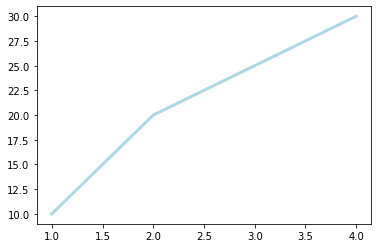

<Figure size 432x288 with 0 Axes>

In [ ]:
x = [1,2,3,4]
y = [10,20,25,30]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y, color='lightblue', linewidth=3)
plt.show()
wandb.init(mode="disabled") # Disable does not sync anything online
log_last_plt_as_wandb_img('Test plot')

## Log plotnine plot as wandb image

In [ ]:
#export
def log_plotnine_as_wandb_img(plot, title):
    r"""Log plotnine object as a wandb.Image"""
    plot.save(filename='./tmp.png', verbose=False)
    wandb.log({title: wandb.Image('./tmp.png')})
    os.system("rm tmp.png")

In [ ]:
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
from plotnine.data import mtcars

foo = (ggplot(mtcars, aes('wt', 'mpg', color='factor(gear)'))
 + geom_point()
 + stat_smooth(method='lm')
 + facet_wrap('~gear'))

In [ ]:
wandb.init(mode="disabled") # Disable does not sync anything online
log_plotnine_as_wandb_img(foo, 'Test plot')

### Export

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
beep(1)

Converted cam.ipynb.
Converted core.ipynb.
Converted data.ipynb.
Converted experiments.ipynb.
Converted index.ipynb.
Converted motion_classification_time_series.ipynb.
Converted utils.ipynb.
